In [30]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import unittest
import os

from skimage.metrics import peak_signal_noise_ratio

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
torch.random.manual_seed(1904)
test = unittest.TestCase()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)
if dev is 'cuda':
  dtype = torch.cuda.FloatTensor
else:
  dtype = torch.FloatTensor
print(f'Using device {device}')

Using device cpu


In [32]:
from models import *
from models.unet import *

input_depth = 3
output_depth = 3

# Change IMAGE to jet|snail
IMAGE = 'jet'
checkpoint_file = f'checkpoints/denoising_{IMAGE}'


if IMAGE == 'snail':
    net = UNet(3, 3, [8, 16, 32, 64, 128], [8, 16, 32, 64, 128], [0, 0, 0, 4, 4],
              [3, 3, 3, 3, 3], [3, 3, 3, 3, 3], [None, None, None, 1, 1]).type(dtype)
elif IMAGE == 'jet':
    net = UNet(3, 3, [128]*5, [128]*5, [4]*5,
              [3]*5, [3]*5, [1]*5).type(dtype)
else:
    assert False

net = net.to(device)
print(f'Image is {IMAGE}')
print(net)

LR = 0.01
num_iter = 2400
show_every = 50

Image is jet
UNet(
  (downs): ModuleList(
    (0): DownsampleBlock(
      (conv1): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (conv2): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): DownsampleBlock(
      (conv1): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (conv2):

In [33]:
s = sum([np.prod(list(p.size())) for p in net.parameters()])
print(f'Number of params: {s}')

# Loss 
mse = torch.nn.MSELoss()

Number of params: 2184307


# Regular Training (no input optimization or adversarial training)

In [34]:
from utils import *
from input_gen import *

reg_noise_std = 1./30.

fname_snail = 'data/denoising/snail.jpg'
fname_jet = 'data/denoising/F16_GT.png'
fname = fname_snail if IMAGE == 'snail' else fname_jet

use_noise = False if IMAGE == 'snail' else True

img_pil = crop_image(get_image(fname, -1)[0])
img_np = pil_to_np(img_pil)
img_tr = torch.from_numpy(img_np)
target_img = img_tr

if use_noise:
    target_noisy_img, _ = add_noise_to_tensor(target_img, 'normal', std=reg_noise_std)
else:
    target_noisy_img = target_img

target_noisy_img = target_noisy_img.unsqueeze(dim=0).to(device)

net_input = get_noise(*img_tr.shape, method='noise').unsqueeze(dim=0).detach().to(device)

noise = net_input.detach().clone()

In [35]:
TRAIN_TYPE = 'regular'

# Train, unless final checkpoint is found
training = True
checkpoint_filename = f'{checkpoint_file}_{TRAIN_TYPE}.pt'
checkpoint_file_final = f'{checkpoint_file}_{TRAIN_TYPE}_final.pt'
if os.path.isfile(checkpoint_file_final):
    training = False
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    net.load_state_dict(saved_state['model_state'])
    net_input = saved_state['net_input']
    saved_psnr = saved_state['best_psnr']
    print(f'Best psnr of saved model : {saved_psnr}')
else:
    # Training loop, can change hyperparameters mid way
    parameters = [x for x in net.parameters()]
    optimizer = torch.optim.Adam(parameters, lr=LR)

    psnr_noisy_res = []
    psnr_gt_res = []
    losses_res = []
    best_psnr = 0
    for i in range(num_iter):
        optimizer.zero_grad()

        if reg_noise_std > 0:
            net_input_mod = net_input + (noise.normal_() * reg_noise_std)
        else:
            net_input_mod = net_input.clone()

        out = net(net_input_mod)
        loss = mse(out, target_noisy_img)
        loss.backward()

        psnr_noisy = peak_signal_noise_ratio(target_noisy_img.detach().cpu().numpy()[0],
                                             out.detach().cpu().numpy()[0])
        psnr_gt = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0]) 

        psnr_noisy_res.append(psnr_noisy)
        psnr_gt_res.append(psnr_gt)
        losses_res.append(loss.item())
        # psrn_gt_sm = peak_signal_noise_ratio(img_np, out_avg.detach().cpu().numpy()[0])
        if psnr_gt > best_psnr:
            best_psnr = psnr_gt
        optimizer.step()

        print('Iteration  %d   Loss = %06f   PSNR noisy = %06f   PSNR gt = %06f' %
              (i, loss.item(), psnr_noisy, psnr_gt), '\r', end='')
        if i % show_every == 0 and i:
            print('Iteration  %d   Loss = %06f   PSNR noisy = %06f   PSNR gt = %06f' %
              (i, loss.item(), psnr_noisy, psnr_gt))
        if i % (show_every*2) == 0:
            fig, axes = tensors_as_images([target_noisy_img[0], out[0].detach()], 
                                            titles=['Original', f'Iteration: {i}'])

    print(f'Done training final Loss = {loss.item()}   PSNR = {psnr_noisy}   PSNR gt = {psnr_gt}')
    fig, axes = tensors_as_images([target_noisy_img[0], out[0].detach()], 
                                            titles=['Original', f'Iteration: {num_iter}'])
    saved_state = dict(best_psnr=best_psnr, model_state=net.state_dict(), net_input=net_input)
    torch.save(saved_state, checkpoint_filename)
    print(f'*** Saved checkpoint {checkpoint_filename} ***')

*** Loading final checkpoint file checkpoints/denoising_jet_regular_final.pt instead of training
Best psnr of saved model : 31.449830216221297


In [36]:
def plot_experiment_results(results, exp_name, fig=None):
    if fig is None:
        fig, _ = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(18,12))
    for i, plot_type in enumerate(('psnr_noisy', 'psnr', 'loss')):
        ax = fig.axes[i]
        if plot_type not in results:
            continue
        exp_res = results[plot_type]    
        ax.plot(list(range(len(exp_res))), exp_res, label=exp_name)
        ax.set_title(plot_type)
        ax.set_xlabel('iteration')
        ax.legend()
    return fig

experiments_results_fig = None

In [37]:
if training:
    experiments_results_fig = plot_experiment_results({'psnr': psnr_gt_res, 'psnr_noisy': psnr_noisy_res, 'loss': losses_res}, 'Regular')

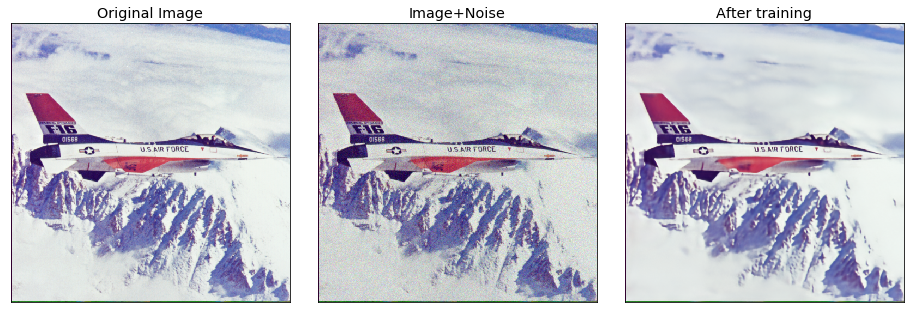

In [38]:
# Showing result of the training using original noise
with torch.no_grad():
    original_noise = net_input
    output = net(original_noise).detach()
    output = output.squeeze(dim=0)
    fig, axes = tensors_as_images([img_tr, target_noisy_img.squeeze(dim=0), output], 
                                        titles=['Original Image', 'Image+Noise', 'After training'],
                                        figsize=(16,16))
    output_pil = np_to_pil(output.detach().cpu().numpy())
    output_pil.save(f'results/denoising/{IMAGE}.png')
    regular_trained_output = output

# Regular Training with input optimization

In [39]:
TRAIN_TYPE = 'input_optim'

USE_SAME_NET = False
if not USE_SAME_NET:
    if IMAGE == 'snail':
        net = UNet(3, 3, [8, 16, 32, 64, 128], [8, 16, 32, 64, 128], [0, 0, 0, 4, 4],
                  [3, 3, 3, 3, 3], [3, 3, 3, 3, 3], [None, None, None, 1, 1]).type(dtype)
    elif IMAGE == 'jet':
        net = UNet(3, 3, [128]*5, [128]*5, [4]*5,
                  [3]*5, [3]*5, [1]*5).type(dtype)
    else:
        assert False
    net.to(device)

new_input = net_input.clone().detach()

LR = 0.01
num_iter = 2400

In [40]:
# Train, unless final checkpoint is found
training = True
checkpoint_filename = f'{checkpoint_file}_{TRAIN_TYPE}.pt'
checkpoint_file_final = f'{checkpoint_file}_{TRAIN_TYPE}_final.pt'
if os.path.isfile(checkpoint_file_final):
    training = False
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    net.load_state_dict(saved_state['model_state'])
    net_input = saved_state['net_input']
    saved_psnr = saved_state['best_psnr']
    print(f'Best psnr of saved model : {saved_psnr}')
else:
    # Training loop, can change hyperparameters mid way
    if USE_SAME_NET:
        optimizer = torch.optim.Adam([new_input.requires_grad_()], lr=LR)
    else:
        parameters = [x for x in net.parameters()]
        optimizer = torch.optim.Adam([net_input.requires_grad_(), *parameters], lr=LR)

    in_opt_psnr_noisy_res = []
    in_opt_psnr_gt_res = []
    in_opt_losses_res = []
    best_psnr = 0
    
    for i in range(num_iter):
        optimizer.zero_grad()
        out = net(new_input)
        loss = mse(out, target_noisy_img)
        loss.backward()
        psnr_noisy = peak_signal_noise_ratio(target_noisy_img.detach().cpu().numpy()[0],
                                             out.detach().cpu().numpy()[0])
        psnr_gt = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0]) 
        # psrn_gt_sm = peak_signal_noise_ratio(img_np, out_avg.detach().cpu().numpy()[0])
        
        in_opt_psnr_noisy_res.append(psnr_noisy)
        in_opt_psnr_gt_res.append(psnr_gt)
        in_opt_losses_res.append(loss.item())
        if psnr_gt > best_psnr:
            best_psnr = psnr_gt
        optimizer.step() 
        print('Iteration  %d   Loss = %06f   PSNR noisy = %06f   PSNR gt = %06f' %
              (i, loss.item(), psnr_noisy, psnr_gt), '\r', end='')
        if i % show_every == 0 and i:
            print('Iteration  %d   Loss = %06f   PSNR noisy = %06f   PSNR gt = %06f' %
              (i, loss.item(), psnr_noisy, psnr_gt))
        if i % (show_every*2) == 0:
            fig, axes = tensors_as_images([target_noisy_img[0], out[0].detach()], 
                                            titles=['Original', f'Iteration: {i}'])
    print(f'Done training final Loss = {loss.item()}   PSNR = {psnr_noisy}   PSNR gt = {psnr_gt}')
    fig, axes = tensors_as_images([target_noisy_img[0], out[0].detach()], 
                                            titles=['Original', f'Iteration: {num_iter}'])
    saved_state = dict(best_psnr=best_psnr, model_state=net.state_dict(), net_input=net_input)
    torch.save(saved_state, checkpoint_filename)
    print(f'*** Saved checkpoint {checkpoint_filename} ***')

*** Loading final checkpoint file checkpoints/denoising_jet_input_optim_final.pt instead of training
Best psnr of saved model : 35.62686375230711


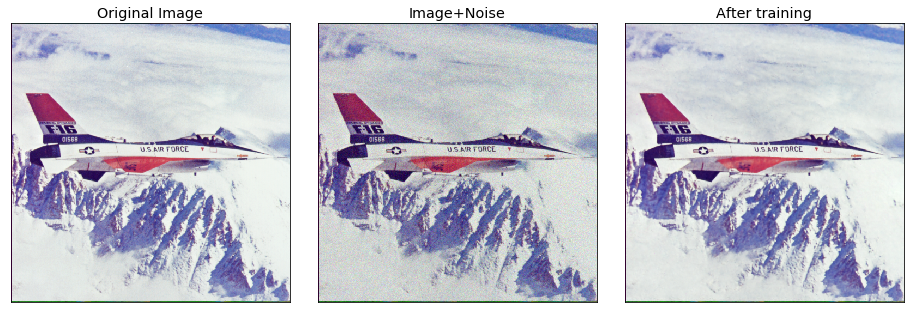

In [41]:
# Showing result of the training using original noise
with torch.no_grad():
    optimized_noise = new_input
    output = net(optimized_noise).detach()
    output = output.squeeze(dim=0)
    fig, axes = tensors_as_images([img_tr, target_noisy_img.squeeze(dim=0), output], 
                                        titles=['Original Image', 'Image+Noise', 'After training'],
                                        figsize=(16,16))
    output_pil = np_to_pil(output.detach().cpu().numpy())
    output_pil.save(f'results/denoising/{IMAGE}_input_optimization.png')
    input_optimized_trained_output = output

In [ ]:
if training:
    experiments_results_fig = plot_experiment_results({'psnr': in_opt_psnr_gt_res, 'psnr_noisy': in_opt_psnr_noisy_res, 'loss': in_opt_losses_res}, 'Input Optim', fig=experiments_results_fig);

# Adversarial Training

In [45]:
from models.adverserialModel import *

TRAIN_TYPE = 'adversarial'

# Models
if IMAGE == 'snail':
    gen = UNet(3, 3, [8, 16, 32, 64, 128], [8, 16, 32, 64, 128], [0, 0, 0, 4, 4],
              [3, 3, 3, 3, 3], [3, 3, 3, 3, 3], [None, None, None, 1, 1])
    num_iter = 30000
    OPTIMIZE_INPUT = False
    INP_LR = 0.01

elif IMAGE == 'jet':
    gen = UNet(3, 3, [128]*5, [128]*5, [4]*5,
              [3]*5, [3]*5, [1]*5)
    num_iter = 30000
    OPTIMIZE_INPUT = False
    INP_LR = 0.01

else:
    assert False
    
gen.to(device)
# gen = net 
dsc = Discriminator(img_tr.shape).to(device)

# Hyperparams
DSC_LR = 0.005
GEN_LR = 0.001
DATA_LABEL = 1
LABEL_NOISE = 0.2
weight_decay = 0.005

In [46]:
# net input
adv_input = net_input.clone().detach()

# Optimizers
if OPTIMIZE_INPUT:
    inp_optimizer = torch.optim.Adam([adv_input.requires_grad_()], INP_LR, weight_decay=weight_decay)
dsc_optimizer = torch.optim.Adam(dsc.parameters(), DSC_LR, weight_decay=weight_decay)
gen_optimizer = torch.optim.Adam(gen.parameters(), GEN_LR, weight_decay=weight_decay)

# Loss
def dsc_loss_fn(y_data, y_generated):
    return discriminator_loss_fn(y_data, y_generated, DATA_LABEL, LABEL_NOISE)

def gen_loss_fn(y_generated):
    return generator_loss_fn(y_generated, DATA_LABEL)


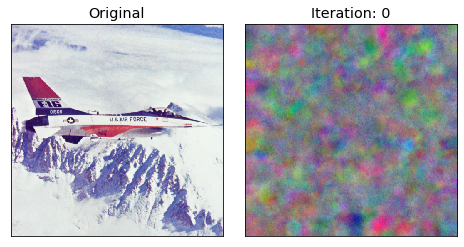

KeyboardInterrupt: 

In [47]:
# Train, unless final checkpoint is found
checkpoint_filename = f'{checkpoint_file}_{TRAIN_TYPE}.pt'
checkpoint_file_final = f'{checkpoint_file}_{TRAIN_TYPE}_final.pt'
training = True
if os.path.isfile(checkpoint_file_final):
    training = False
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    gen.load_state_dict(saved_state['model_state'])
    adv_input = saved_state['net_input']
else:
    # Training loop
    adv_psnr_noisy_res = []
    adv_psnr_gt_res = []
    best_psnr = 0
    for i in range(num_iter):
        if OPTIMIZE_INPUT:
            inp_optimizer.zero_grad()
        dsc_loss, gen_loss, output = train_batch(dsc, gen, dsc_loss_fn, gen_loss_fn,
                                        dsc_optimizer, gen_optimizer,
                                        target_noisy_img, adv_input)
        if OPTIMIZE_INPUT:
            inp_optimizer.step()
            
        psnr_noisy = peak_signal_noise_ratio(target_noisy_img.detach().cpu().numpy()[0],
                                             output.detach().cpu().numpy()[0])
        psnr_gt = peak_signal_noise_ratio(img_np, output.detach().cpu().numpy()[0]) 
        adv_psnr_noisy_res.append(psnr_noisy)
        adv_psnr_gt_res.append(psnr_gt)
        if psnr_gt > best_psnr:
            best_psnr = psnr_gt
        print('Iteration  %d   Gen Loss = %06f   Dsc Loss = %06f   PSNR noisy = %06f   PSNR = %06f' % 
              (i, gen_loss, dsc_loss, psnr_noisy, psnr_gt), '\r', end='')
        if i % show_every == 0 and i:
            print('Iteration  %d   Gen Loss = %06f   Dsc Loss = %06f   PSNR noisy = %06f   PSNR = %06f' % 
                  (i, gen_loss, dsc_loss, psnr_noisy, psnr_gt))
        if i % (show_every*2) == 0:
            fig, axes = tensors_as_images([img_tr, output[0].detach()], 
                                          titles=['Original', f'Iteration: {i}'], cmap='Greys')
    saved_state = dict(best_psnr=best_psnr, model_state=gen.state_dict(), net_input=adv_input)
    torch.save(saved_state, checkpoint_filename)
    print(f'*** Saved checkpoint {checkpoint_filename} ***')

In [ ]:
# Showing result of the training using original noise
with torch.no_grad():
    original_noise = adv_input
    output = gen(original_noise).detach()
    output = output.squeeze(dim=0)
    fig, axes = tensors_as_images([img_tr, regular_trained_output, input_optimized_trained_output, output], 
                                        titles=['Original Image', 'Regular training', 'Input Optim', 'Adversarial training'],
                                        figsize=(16,16), cmap='Greys')
    output_pil = np_to_pil(output.detach().cpu().numpy())
    output_pil.save(f'results/denoising/{IMAGE}_adversarial.png')

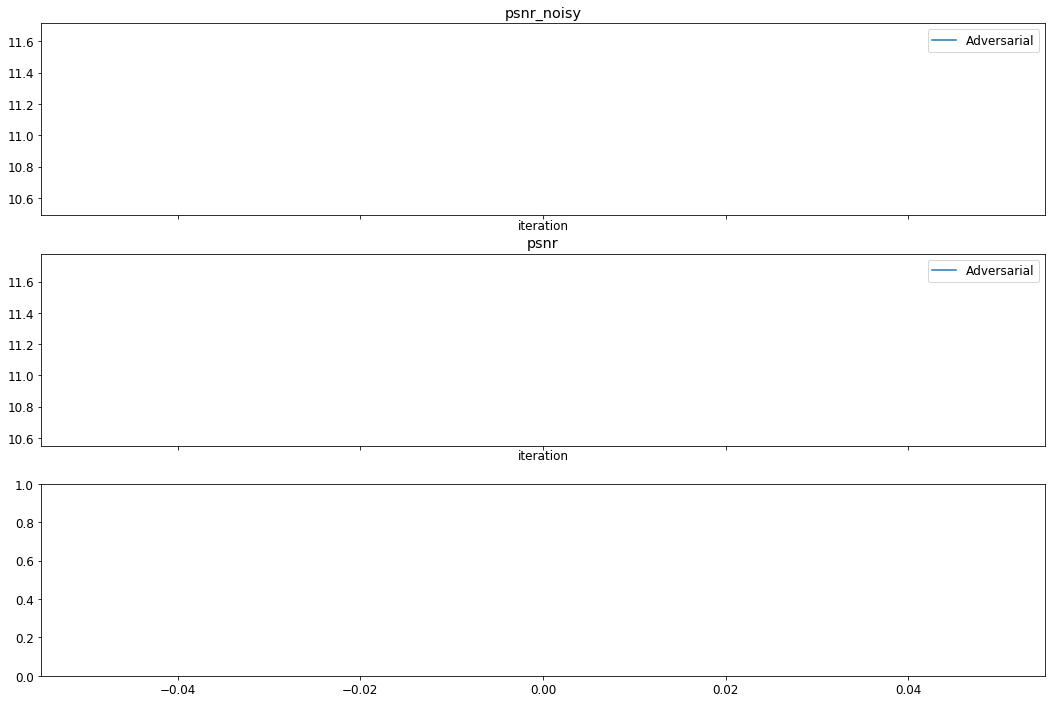

In [49]:
if training:
    experiments_results_fig = plot_experiment_results({'psnr': adv_psnr_gt_res, 'psnr_noisy': adv_psnr_noisy_res}, 'Adversarial', fig=experiments_results_fig)